# Data Collection

I'm focusing on `MildlyInteresting` and `MildlyInfuriating` to do 4 main things:

1. Task 1. Compare these subreddits based on their content from 2013. (see [2013 Data](jn_1_2013_data.ipynb))
2. Task 2. Compare these subreddits based on their content from 2017. (see [2017 Data](jn_2_2017_data.ipynb))
3. Task 3. Individually compare each subreddit based on their content from 2013 and 2017. (see [2017 Data](jn_2_2017_data.ipynb))
4. Task 4. Predict which subreddit a new post made in 2018 belongs to. (see [2017 Data](jn_2_2017_data.ipynb))

I want to use reddit to not only advertise my product, but to also hurt my competitors. Taking what I learned from my above 4 goals, can I casually advertise my product, with success, on `MildlyInteresting` and "smack talk" on my competitors on `MildlyInfuriating`?

To do that, I'm going to need every post from 2013 and 2017. To do that, and to ensure I have more than enough data, I'm going to collect every reddit submission on that subreddit from it's start. My script to collect this data is location here [scrape.py](./scrape.py).

## Local EDA

Given that I collected over 3gbs of data, I want to do some basic eda here using 1000 posts from each subreddit. I'll check to see if there is any cleaning needed, if I can get rid of unnecessary meta-data features, and do quick vectorizing and modelling.

In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
with open('../data/mildlyinteresting/2012/data_1334689410.json') as f:
    data1a = json.load(f)

with open('../data/mildlyinteresting/2012/data_1338145061.json') as f:
    data1b = json.load(f)
    
with open('../data/mildlyinfuriating/2012/data_1352731417.json') as f:
    data2a = json.load(f)

with open('../data/mildlyinfuriating/2012/data_1356800277.json') as f:
    data2b = json.load(f)

In [3]:
df_train = pd.DataFrame(data=data1a['data']+data2a['data'], columns=['title','subreddit'])
df_test = pd.DataFrame(data=data1b['data']+data2b['data'], columns=['title','subreddit'])

In [4]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

In [5]:
X_train = df_train['title']
y_train = df_train['subreddit']
X_test = df_test['title']
y_test = df_test['subreddit']
subreddits = ['mildlyinfuriating','mildlyinteresting']

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
tfidf = TfidfVectorizer(
                        min_df=1,
                        max_df=.75,
                        analyzer='word',
                        stop_words='english',
                        token_pattern=r'\w{1,}',
                        strip_accents='unicode')

In [8]:
train_tf = tfidf.fit_transform(X_train,y_train)
test_tf = tfidf.transform(X_test)

In [9]:
print('There are currently {} features included from this training data'.format(len(tfidf.get_feature_names())))

There are currently 4235 features included from this training data


In [10]:
lr = LogisticRegression(C=1, max_iter=100, solver='saga', random_state=42)

In [11]:
lr.fit(train_tf, y_train)
y_pred = lr.predict(test_tf)
y_pred_prob = lr.predict_proba(test_tf)[:, 1]

**How well does this base model do?**

In [12]:
print('Train data score: {} \nTest data score: {}'.format(lr.score(train_tf,y_train),lr.score(test_tf,y_test)))

Train data score: 0.9445843828715366 
Test data score: 0.7402010050251256


**These scores are highly overfit to the train data. This is something that I can address in the coming notebooks.**

In [13]:
pred_df = pd.DataFrame({'True':y_test,'Pred':y_pred,'Same':y_test == y_pred})

In [14]:
pred_df['Same'].value_counts()

True     1473
False     517
Name: Same, dtype: int64

In [15]:
confusion_matrix(y_test,y_pred)

array([[786, 210],
       [307, 687]], dtype=int64)

In [16]:
coefs_df = pd.DataFrame({"Feature":tfidf.get_feature_names(),"Weight":lr.coef_[0],"Positive":lr.coef_[0] > 0})

**These are the top 10 features that make a post `mildlyinteresting`. I will need to remove `interesting` when I continue modeling.** There are a few words I might consider removing if they continue to be such huge factors in my actual data. Words like (1) just, (2) saw, (3) think, (4) got.

I was planning on dropping `til` however, knowing my data, I know that refers to `Today I Learned` which is quite common and used to interesting things.

In [17]:
coefs_df.sort_values('Weight',ascending=False).head(10)

,Feature,Weight,Positive
3816,today,3.771312,True
223,ama,3.405583,True
1875,interesting,3.353929,True
1959,just,2.758685,True
1965,karma,2.563135,True
3168,saw,1.941276,True
3795,til,1.552679,True
3762,think,1.544084,True
1598,got,1.469454,True
2472,night,1.411890,True


**These are the top 10 features that make a post `mildlyinfuriating`. I will need to remove `infuriating` when I continue modeling.** There are a few words I might consider removing if they continue to be such huge factors in my actual data. Words like (1) click*, (2) use.

On the list of the top 15, I see two words that have the same root. Such as `trying` and `try`. It would be good for me to lemmatize these words so that I properly take these into account.

In [18]:
coefs_df.sort_values('Weight').head(10)

,Feature,Weight,Positive
2663,people,-3.233268,False
3281,shit,-1.632613,False
1512,fucking,-1.399552,False
1848,infuriating,-1.378180,False
1110,doesn,-1.365566,False
751,click,-1.299229,False
3892,trying,-1.264771,False
3891,try,-1.248287,False
2685,phone,-1.180215,False
3990,use,-1.146241,False


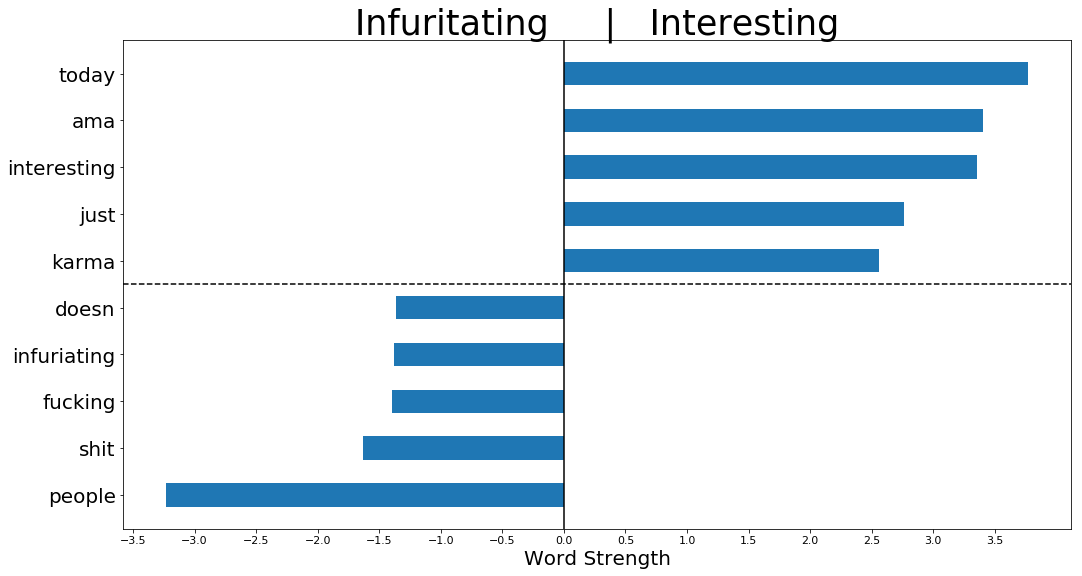

In [20]:
a = coefs_df[(coefs_df['Weight'] >= 2.563135) | (coefs_df['Weight'] <= -1.36556)].sort_values('Weight')['Weight']
b = coefs_df[(coefs_df['Weight'] >= 2.563135) | (coefs_df['Weight'] <= -1.36556)].sort_values('Weight')['Feature']

N = len(a)
ind = np.arange(N)
width= .5

plt.barh(ind, a, width) #, color=coefs_df['Positive'].map({True: 'orange', False: 'purple'})
                        # doing this somehow still displays wrong colors.

plt.xlabel('Word Strength',fontsize=20)
plt.title('Infuritating     |   Interesting',fontsize=35)
plt.yticks(ind, b,fontsize=20, rotation=0)

plt.xticks(np.arange(-3.5, 4, .5),fontsize=11)

plt.axvline(x=0.0, c='black')
plt.axhline(y=4.5, c='black', linestyle='--')

a = plt.gcf()
a.set_size_inches(17, 9)

plt.show()

**It's nice to always be able to visualize how impactful these words are in respect to one another. For example, in regrads to the `interesting` words, they all gradually get more strength, but when it comes to `infuriating` `people` takes a huge jump up.**

In [21]:
term_df = pd.SparseDataFrame(train_tf, columns=tfidf.get_feature_names())

In [22]:
term_df.shape

(1985, 4235)

In [23]:
term_df.fillna(0, inplace=True)

In [24]:
def exp_variance(n):
    SVD = TruncatedSVD(n_components=n)
    svd_matrix = SVD.fit_transform(term_df)
    svd_matrix.shape

    fig = plt.figure(figsize=(10,5))
    plt.bar(np.array(range(n))+1, 
            SVD.explained_variance_ratio_, 
            color='g', 
            label='Explained Cariance')
    plt.plot(np.array(range(n))+1, 
             np.cumsum(SVD.explained_variance_ratio_), 
             label='Cumulative Explained Variance')
    plt.legend(fontsize=11)
    plt.xlabel('Component', fontsize=13)
    plt.ylabel('Variance Ratio', fontsize=13)
    plt.title('Explained Variance by Component', fontsize=19)

**`Explained Variance` is the ratio between the variance of that principal component and the total variance. This allows us to see, how many of the words in the entire corpora capture that explained variance. To see 100% of that variance, we need to see every word. However, we can suffice if we're able to see between 70-80% of our explained variance. I can be comfortable knowing that I've used enough features to stay true to the variance within my data.** 

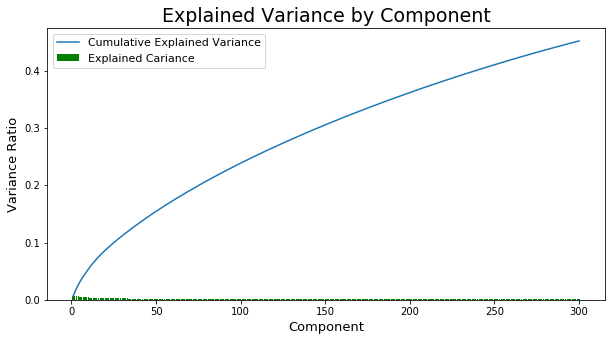

In [25]:
exp_variance(300)

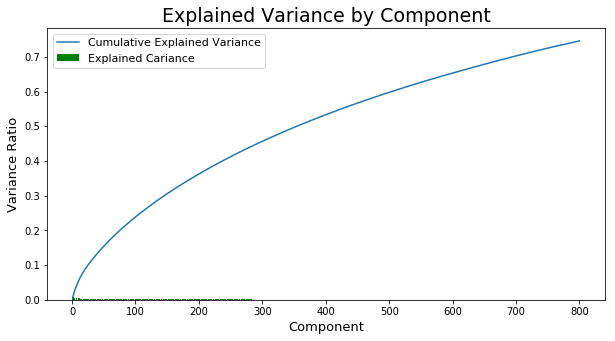

In [26]:
exp_variance(800)

**800 features, out of a total of 4235 (with some dropped with `min/max_df`), gets me close enough to 80% explained variance. I didn't include too many features that wouldn't give me much insight, nor did I use too few that would make my inferences baseless.** 